In [1]:
import json
import os
import time
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn.functional as F
import torch.nn.init as init

# Constants
d1, d = 2500, 50
m, B = 80, 50 * 10
total_samples, test_samples = 5000, 2000
Sw = total_samples
Sh = 3000
sigma_xi = 8/d

class MulticlassImageTextDataset(Dataset):
    def __init__(self, total_samples, M, d1, d, sigma_xi, num_classes=5):
        self.total_samples = total_samples
        self.M = M
        self.d1, self.d = d1, d
        self.sigma_xi = sigma_xi
        self.num_classes = num_classes
        self.segment_size = d // num_classes
        
        # Define text labels for each class
        self.text_labels = [
            "zero", "one", "two", "three", "four", 
            "five", "six", "seven", "eight", "nine"
        ]
        # self.text_labels = [
        #     "zero", "one", "two", "three", "four", 
        #     "five"
        # ]

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        while True:
            # Generate z_x using Bernoulli distribution
            z_x = torch.bernoulli(torch.full((self.d,), 0.1))

            # Determine the class based on which segment has the most 1s
            segments = z_x.view(self.num_classes, -1)
            segment_sums = segments.sum(dim=1)
            
            # Sort segment sums in descending order
            sorted_sums, _ = torch.sort(segment_sums, descending=True)
            
            # Check if the maximum sum is at least 2 more than the second highest
            # and there are no ties for the maximum
            if sorted_sums[0] >= sorted_sums[1] + 2:
                break

        # Now determine the true class (no need to break ties)
        true_class = torch.argmax(segment_sums)

        # Create one-hot encoding for the class
        one_hot = torch.zeros(self.num_classes)
        one_hot[true_class] = 1

        # Generate x
        noise = torch.randn(self.d1) * self.sigma_xi
        x = torch.matmul(self.M, z_x) + noise

        # Get the text label for the class
        y_text = self.text_labels[true_class]

        return x, y_text, z_x, one_hot

def create_dataset(total_samples, M, d1=d1, d=d, sigma_xi=sigma_xi, num_classes=5, batch_size=B, train_ratio=0.8):
    dataset = MulticlassImageTextDataset(total_samples, M, d1, d, sigma_xi, num_classes)
    
    # Split the dataset into train and test
    train_size = int(train_ratio * total_samples)
    test_size = total_samples - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

class ImageTextDataset(Dataset):
    def __init__(self, total_samples, M, H, d1, d, sigma_xi, noise_prob=0.5):
        self.total_samples, self.M, self.H = total_samples, M, H
        self.d1, self.d, self.sigma_xi, self.noise_prob = d1, d, sigma_xi, noise_prob

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        # Generate z_x
        z_x = torch.bernoulli(torch.full((self.d,), 0.1))
        
        # Determine if z_y should be random or equal to z_x
        if torch.rand(1).item() < self.noise_prob:
            # Generate z_y randomly
            z_y = torch.bernoulli(torch.full((self.d,), 0.1))
        else:
            # Set z_y equal to z_x
            z_y = z_x.clone()
        
        xi_x, xi_y = torch.randn(self.d1) * self.sigma_xi, torch.randn(self.d1) * self.sigma_xi
        x, y = torch.matmul(z_x, self.M.T) + 0*xi_x, torch.matmul(z_y, self.H.T) + xi_y
        return x, y, z_x, z_y

class SequentialSpecializedImageTextDataset(Dataset):
    def __init__(self, M, H, d1, d, sigma_xi):
        self.M, self.H = M, H
        self.d1, self.d, self.sigma_xi = d1, d, sigma_xi
        self.total_samples = d  # 总样本数等于 d

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        if idx >= self.d:
            raise IndexError("Index out of bounds")

        # 创建一个只在 idx 位置有 1 的向量
        z = torch.zeros(self.d)
        z[idx] = 1.0

        # z_x 和 z_y 相同
        z_x = z
        z_y = z

        # 生成 x 和 y
        xi_y = torch.randn(self.d1) * self.sigma_xi
        x = torch.matmul(z_x, self.M.T)  # 注意：这里不添加噪声
        y = torch.matmul(z_y, self.H.T) + xi_y

        return x, y, z_x, z_y

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, output_dim, bias=True)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        init.normal_(self.linear1.weight, mean=0.0, std=1e-3)
        if self.linear1.bias is not None:
            # init.zeros_(self.linear1.bias)
            init.normal_(self.linear1.bias, mean=0.0, std=1e-3)
    
    def _normalize_weights_and_bias(self):
        with torch.no_grad():
            norms = torch.norm(self.linear1.weight, p='fro', dim=1)
            norms_unsqueezed = norms.unsqueeze(1)
            self.linear1.weight.div_(norms_unsqueezed)
            if self.linear1.bias is not None:
                self.linear1.bias.div_(norms_unsqueezed.squeeze())

    def forward(self, x):
        self._normalize_weights_and_bias()
        x = self.relu(self.linear1(x))
        return x

def check_matrix_mult_threshold(W_image, M, threshold=0.8):
    # 确保 W_image 和 M 在同一设备上
    W_image = W_image.to(device)
    M = M.to(device)
    
    # 执行矩阵乘法
    result = torch.matmul(W_image, M)
    
    # 检查哪些值大于阈值
    above_threshold = (result > threshold).float()
    
    # 计算每行中大于阈值的元素数量
    count_above_threshold = above_threshold.sum(dim=1)
    
    # 统计信息
    total_above = above_threshold.sum().item()
    mean_above = count_above_threshold.mean().item()
    max_above = count_above_threshold.max().item()
    min_above = count_above_threshold.min().item()
    
    # 计算达到最大值和最小值的行数
    max_count = (count_above_threshold == max_above).sum().item()
    min_count = (count_above_threshold == min_above).sum().item()
    
    # print(f"Total elements > {threshold}: {total_above}")
    # print(f"Mean elements > {threshold} per row: {mean_above:.2f}")
    # print(f"Max elements > {threshold} in a row: {max_above}")
    # print(f"Number of rows with max elements: {max_count}")
    # print(f"Min elements > {threshold} in a row: {min_above}")
    # print(f"Number of rows with min elements: {min_count}")
    
    return above_threshold, count_above_threshold

def info_nce_loss(features, image_encoder=None, text_encoder=None, lambda_w=0.001, lambda_v=0.001, temperature=0.1):
    device = features.device
    batch_size = features.shape[0] // 2
    
    # 创建标签
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0).to(device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(device)
    
    # 计算相似性矩阵
    similarity_matrix = torch.matmul(features, features.T) / temperature
    
    # 创建掩码并移除对角线元素
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    
    # 计算正样本和负样本的相似性
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
    
    # 拼接 logits 并计算损失
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)
    loss = F.cross_entropy(logits, labels)
    
    # 计算 Frobenius 正则化项（如果有 encoder）
    if image_encoder is not None:
        W_frobenius_squared = sum(torch.norm(param, p='fro') ** 2 for param in image_encoder.parameters())
        loss += lambda_w * W_frobenius_squared
    
    if text_encoder is not None:
        V_frobenius_squared = sum(torch.norm(param, p='fro') ** 2 for param in text_encoder.parameters())
        loss += lambda_v * V_frobenius_squared
    
    return loss

def evaluate_model(test_dataset, image_encoder, text_encoder):
    device = image_encoder.linear1.weight.device
    x, y, z_x, z_y = map(lambda t: t.to(device), map(torch.stack, zip(*[test_dataset[i] for i in range(len(test_dataset))])))
    
    feature_x, feature_y = image_encoder(x), text_encoder(y)
    feature_x_norm, feature_y_norm = F.normalize(feature_x, p=2, dim=1), F.normalize(feature_y, p=2, dim=1)
    result_features = torch.matmul(feature_x_norm, feature_y_norm.T)
    
    z_x_norm, z_y_norm = F.normalize(z_x.float(), p=2, dim=1), F.normalize(z_y.float(), p=2, dim=1)
    result_z = torch.matmul(z_x_norm, z_y_norm.T)
    
    error_matrix = torch.abs(result_features - result_z)
    
    diag_avg_features = torch.mean(torch.diagonal(result_features)).item()
    non_diag_avg_features = (torch.sum(result_features) - torch.sum(torch.diagonal(result_features))).item() / (result_features.numel() - result_features.size(0))
    mean_error = torch.mean(error_matrix).item()
    diagonal_error = torch.mean(torch.abs(torch.diagonal(result_features) - torch.diagonal(result_z))).item()
    non_diagonal_error = (torch.sum(error_matrix) - torch.sum(torch.diagonal(error_matrix))).item() / (result_features.size(0) ** 2 - result_features.size(0))
    correlation = torch.corrcoef(torch.stack([result_features.flatten(), result_z.flatten()]))[0, 1].item()
    
    results = [diag_avg_features, non_diag_avg_features, mean_error, diagonal_error, non_diagonal_error, correlation]
    
    print(f"Avg diagonal: {results[0]:.4f}")
    print(f"Avg non-diagonal: {results[1]:.4f}")
    # print(f"Mean error: {results[2]:.4f}")
    # print(f"Diagonal error: {results[3]:.4f}")
    # print(f"Non-diagonal error: {results[4]:.4f}")
    # print(f"Correlation: {results[5]:.4f}")
    
    return results

def compare_results(results_dict):
    metrics = ["Avg diagonal", "Avg non-diagonal", "Mean error", "Diagonal error", "Non-diagonal error", "Correlation"]
    noise_probs = list(results_dict.keys())
    
    print("\nComparison of results (all evaluated on clean test data):")
    header = "Metric".ljust(20) + "".join([f"Train Noise {np:.2f}".ljust(20) for np in noise_probs])
    print(header)
    print("-" * len(header))
    
    for i, metric in enumerate(metrics):
        row = metric.ljust(20)
        for np in noise_probs:
            row += f"{results_dict[np][i]:<20.4f}"
        print(row)

def extract_encoder_parameters(encoder):
    """
    从编码器中提取线性层的权重和偏置。
    可用于 image_encoder 或 text_encoder。
    """
    if not hasattr(encoder, 'linear1'):
        raise AttributeError("Encoder does not have a 'linear1' attribute. Check the encoder structure.")
    
    # 提取权重 W
    W = encoder.linear1.weight.data.clone()
    
    # 提取偏置 b
    b = encoder.linear1.bias.data.clone() if encoder.linear1.bias is not None else None
    
    return W, b

class ModifiedSwDataset(Dataset):
    def __init__(self, original_dataset, replaced_samples):
        self.original_dataset = original_dataset
        self.replaced_samples = replaced_samples

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        x, _, z_x, z_y = self.original_dataset[idx]
        x = torch.tensor(x, dtype=torch.float32) if not torch.is_tensor(x) else x
        replaced_y = torch.tensor(self.replaced_samples[idx], dtype=torch.float32)
        z_x = torch.tensor(z_x, dtype=torch.float32) if not torch.is_tensor(z_x) else z_x
        z_y = torch.tensor(z_y, dtype=torch.float32) if not torch.is_tensor(z_y) else z_y

        return x, replaced_y, z_x, z_y

class SmallDatasetImageDecoder(nn.Module):
    def __init__(self, input_dim=2500, hidden_dim=80, output_dim=2500):
        super(SmallDatasetImageDecoder, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)

def generate_and_replace_samples(image_decoder, dataset, batch_size=500):
    image_decoder.eval()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    replaced_samples = []

    with torch.no_grad():
        for batch_idx, (x_batch, y_batch, z_x_batch, z_y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            
            new_y_batch = image_decoder(x_batch)
            
            replaced_samples.extend(new_y_batch.cpu().numpy())

            if (batch_idx + 1) % 10 == 0:
                print(f'Processed {batch_idx + 1} batches')

    print(f"Total samples replaced: {len(replaced_samples)}")
    replacement_ratio = len(replaced_samples) / len(dataset)
    
    return ModifiedSwDataset(dataset, replaced_samples), replacement_ratio

def train_decoder(model, train_loader, device, num_epochs=40, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, _, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            # learning_rate = learning_rate * 0.5
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

def train_and_evaluate(filtered_train_loader, epochs=20, lr=3e-3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    image_encoder = Encoder(input_dim=d1, output_dim=m).to(device)
    text_encoder = Encoder(input_dim=d1, output_dim=m).to(device)
    optimizer = torch.optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=lr)
    for epoch in range(epochs):
        for x_batch, y_batch, _, _ in filtered_train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            features = torch.cat([image_encoder(x_batch), text_encoder(y_batch)], dim=0)
            loss = info_nce_loss(features, image_encoder, text_encoder)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    test_dataset_clean = ImageTextDataset(total_samples=test_samples, M=M, H=H, d1=d1, d=d, sigma_xi=sigma_xi, noise_prob=0)
    # print(f"\nEvaluation on clean test dataset (trained with filtered dataset):")
    results = evaluate_model(test_dataset_clean, image_encoder, text_encoder)

    return results, image_encoder, text_encoder

def finetune(pre_trained_image_encoder, pre_trained_text_encoder, train_dataset_Sh, test_dataset_clean, epochs=40, lr=1e-3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    image_encoder = Encoder(input_dim=d1, output_dim=m).to(device)
    text_encoder = Encoder(input_dim=d1, output_dim=m).to(device)
    image_encoder.load_state_dict(pre_trained_image_encoder.state_dict())
    text_encoder.load_state_dict(pre_trained_text_encoder.state_dict())

    optimizer = torch.optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_loader = DataLoader(train_dataset_Sh, batch_size=B, shuffle=True, num_workers=4, pin_memory=True)

    for epoch in range(epochs):
        image_encoder.train()
        text_encoder.train()
        for x_batch, y_batch, _, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            features = torch.cat([image_encoder(x_batch), text_encoder(y_batch)], dim=0)
            loss = info_nce_loss(features, image_encoder, text_encoder)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    final_eval_results = evaluate_model(test_dataset_clean, image_encoder, text_encoder)
    # print("\nEvaluation on clean test dataset:", final_eval_results)
    return final_eval_results, image_encoder, text_encoder

def analyze_matrix_mult_results(W_image, M, threshold=0.5):
    device = W_image.device
    M = M.to(device)
    
    # Normalize W_image
    norms = torch.norm(W_image, p='fro', dim=1)
    norms_unsqueezed = norms.unsqueeze(1)
    W_image_normalized = W_image.div(norms_unsqueezed)
    
    result = torch.matmul(W_image_normalized, M)
    above_threshold = (torch.abs(result) > threshold).float()
    
    single_position_rows = {}
    total_magnitude = 0
    for i, row in enumerate(above_threshold):
        positions = row.nonzero().squeeze().tolist()
        if isinstance(positions, int):  # If only one position, convert to list
            positions = [positions]
        if len(positions) == 1:
            single_position_rows[i] = positions[0]
            total_magnitude += torch.abs(result[i, positions[0]]).item()

    unique_positions = set(single_position_rows.values())
    unique_count = len(unique_positions)
    
    avg_magnitude = total_magnitude / unique_count if unique_count > 0 else 0

    return single_position_rows, unique_count, avg_magnitude


# class ModifiedSwDataset(Dataset):
    def __init__(self, original_dataset, kept_indices):
        self.original_dataset = original_dataset
        self.kept_indices = kept_indices

    def __len__(self):
        return len(self.kept_indices)

    def __getitem__(self, idx):
        return self.original_dataset[self.kept_indices[idx]]

def optimize_analyze_matrix_mult_results(W_image, M, threshold_start=0.2, threshold_end=1.0, threshold_step=0.05):
    max_unique_count = 0
    optimal_avg_magnitude = 0

    for threshold in torch.arange(threshold_start, threshold_end + threshold_step, threshold_step):
        single_position_rows, unique_count, avg_magnitude = analyze_matrix_mult_results(W_image, M, threshold=threshold.item())

        if unique_count > max_unique_count:
            max_unique_count = unique_count
            optimal_avg_magnitude = avg_magnitude

    return max_unique_count, optimal_avg_magnitude

def generate_new_dataset(image_decoder, image_encoder, text_encoder, original_dataset, batch_size):
    image_decoder.eval()
    
    dataloader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    new_data = []
    replaced_count = 0
    
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch, z_x_batch, z_y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Generate new y using the decoder
            new_y_batch = image_decoder(x_batch)
            
            encoded_x = image_encoder(x_batch)
            encoded_y = text_encoder(y_batch)
            encoded_new_y = text_encoder(new_y_batch)
            
            cos_sim_original = F.cosine_similarity(encoded_x, encoded_y, dim=1)
            cos_sim_new = F.cosine_similarity(encoded_x, encoded_new_y, dim=1)
            
            similarity_threshold = 1.2
            # if np < 0.3:
            #     similarity_threshold = 1.2
            # else:
            #     similarity_threshold = 1.2
            
            # Calculate cosine similarity
            # cos_sim_new = F.cosine_similarity(x_batch, new_y_batch)
            # cos_sim_original = F.cosine_similarity(x_batch, y_batch)
            
            # Compare similarities and filter data
            
            for x, y, new_y, z_x, z_y, sim_new, sim_original in zip(x_batch, y_batch, new_y_batch, z_x_batch, z_y_batch, cos_sim_new, cos_sim_original):
                if sim_new >= similarity_threshold * sim_original:
                    new_data.append((x.cpu(), new_y.cpu(), z_x, z_y))
                    replaced_count += 1
                else:
                    new_data.append((x.cpu(), y.cpu(), z_x, z_y))  # Keep original if similarity is too low

            if (batch_idx + 1) % 10 == 0:
                print(f'Processed {batch_idx + 1} batches')

    replacement_ratio = replaced_count / len(original_dataset)
    print(f"Replacement ratio: {replacement_ratio:.2%}")
    print(f"Samples with new y: {sum(1 for _, y, _, _ in new_data if not torch.allclose(y, original_dataset[_][1]))}")
    
    return NewDataset(new_data), replacement_ratio

class NewDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y, z_x, z_y = self.data[idx]
        return (
            x.clone().detach() if torch.is_tensor(x) else torch.tensor(x, dtype=torch.float32),
            y.clone().detach() if torch.is_tensor(y) else torch.tensor(y, dtype=torch.float32),
            z_x.clone().detach() if torch.is_tensor(z_x) else torch.tensor(z_x, dtype=torch.float32),
            z_y.clone().detach() if torch.is_tensor(z_y) else torch.tensor(z_y, dtype=torch.float32)
        )

def train_decoder(decoder, train_loader, num_epochs=50, learning_rate=1e-3):
    decoder.train()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch, _, _ in train_loader:
            # 设备检查
            if x_batch.device != device:
                x_batch = x_batch.to(device)
            if y_batch.device != device:
                y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = decoder(x_batch)
            
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
            learning_rate = learning_rate * 0.5

class CustomSmallDatasetImageDecoder(nn.Module):
    def __init__(self, M, H, use_given_matrices=True):
        super(CustomSmallDatasetImageDecoder, self).__init__()
        
        d1, m = M.shape
        assert M.shape == (d1, m), f"M should be of shape ({d1}, {m})"
        assert H.shape == (d1, m), f"H should be of shape ({d1}, {m})"
        
        self.model = nn.Sequential(
            nn.Linear(d1, m, bias=True),
            nn.ReLU(),
            nn.Linear(m, d1, bias=True)
        )
        
        if use_given_matrices:
            # Set the weights of the first and last linear layers
            self.model[0].weight.data = M.t()  # Transpose of M
            self.model[2].weight.data = H
            
            # Initialize biases to zero
            nn.init.zeros_(self.model[0].bias)
            nn.init.zeros_(self.model[2].bias)
        else:
            # Random initialization
            nn.init.xavier_uniform_(self.model[0].weight)
            nn.init.xavier_uniform_(self.model[2].weight)
            nn.init.zeros_(self.model[0].bias)
            nn.init.zeros_(self.model[2].bias)

    def forward(self, x):
        return self.model(x)

class MulticlassImageTextDataset(Dataset):
    def __init__(self, total_samples, M, d1, d, sigma_xi, num_classes):
        self.total_samples = total_samples
        self.M = M
        self.d1, self.d = d1, d
        self.sigma_xi = sigma_xi
        self.num_classes = num_classes
        self.segment_size = d // num_classes
        self.text_labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        while True:
            z_x = torch.bernoulli(torch.full((self.d,), 0.1))
            segments = z_x.view(self.num_classes, -1)
            segment_sums = segments.sum(dim=1)
            sorted_sums, _ = torch.sort(segment_sums, descending=True)
            if sorted_sums[0] >= sorted_sums[1] + 2:
                break

        true_class = torch.argmax(segment_sums)
        one_hot = torch.zeros(self.num_classes)
        one_hot[true_class] = 1

        noise = torch.randn(self.d1) * self.sigma_xi
        x = torch.matmul(self.M, z_x) + noise

        y_text = self.text_labels[true_class]

        return x, y_text, z_x, one_hot

class MulticlassTextDataset(Dataset):
    def __init__(self, H, d1, d, sigma_xi, num_classes):
        self.H, self.d1, self.d = H, d1, d
        self.sigma_xi = sigma_xi
        self.num_classes = num_classes
        self.segment_size = d // num_classes
        self.text_labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

    def __len__(self):
        return self.num_classes

    def __getitem__(self, idx):
        z_x = torch.zeros(self.d)
        z_x[idx * self.segment_size : (idx + 1) * self.segment_size] = 1
        
        one_hot = torch.zeros(self.num_classes)
        one_hot[idx] = 1

        noise = torch.randn(self.d1) * self.sigma_xi
        x = torch.matmul(self.H, z_x) + noise

        return x, self.text_labels[idx], z_x, one_hot

def cosine_similarity_gpu(a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    return torch.mm(a_norm, b_norm.transpose(0, 1))

def test_image_text_classification(test_loader, text_data, image_encoder, text_encoder, device):
    # print(f"Starting test_image_text_classification. Text data type: {type(text_data)}, length: {len(text_data)}")
    if len(text_data) == 0:
        print("Error: text_data is empty!")
        return 0.0

    correct = 0
    total = 0
    
    text_samples, _, z_y_samples, _ = text_data
    text_samples = torch.stack([torch.tensor(x) for x in text_samples]).to(device)
    z_y_samples = torch.stack([torch.tensor(z) for z in z_y_samples]).to(device)
    
    with torch.no_grad():
        text_features = text_encoder(text_samples)
    
    for x, y_text, z_x, one_hot in test_loader:
        x, z_x, one_hot = x.to(device), z_x.to(device), one_hot.to(device)
        total += x.size(0)
        
        with torch.no_grad():
            image_features = image_encoder(x)
        
        similarities_x = cosine_similarity_gpu(image_features, text_features)
        similarities_z = cosine_similarity_gpu(z_x, z_y_samples)
        
        pred_x = torch.argmax(similarities_x, dim=1)
        pred_z = torch.argmax(similarities_z, dim=1)
        
        correct_predictions = (pred_x == pred_z) & (pred_x == torch.argmax(one_hot, dim=1))
        correct += torch.sum(correct_predictions).item()
    
    accuracy = correct / total
    return accuracy

def create_dataset(total_samples, M, d1, d, sigma_xi, num_classes, batch_size, train_ratio=0.8):
    dataset = MulticlassImageTextDataset(total_samples, M, d1, d, sigma_xi, num_classes)
    
    train_size = int(train_ratio * total_samples)
    test_size = total_samples - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def create_Text_dataset(H, d1, d, sigma_xi, num_classes):
    # print(f"Creating text dataset with num_classes: {num_classes}")
    dataset = MulticlassTextDataset(H, d1, d, sigma_xi, num_classes)
    all_samples = [dataset[i] for i in range(num_classes)]
    result = list(zip(*all_samples))
    # print(f"Text dataset created. Number of samples: {len(result[0])}")
    return result

def run_single_experiment(np, M, H, d1, d, sigma_xi, Sw, test_samples, B, downstream_total_samples=5000, num_classes=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # 创建数据集和数据加载器
    train_dataset_Sw = ImageTextDataset(total_samples=Sw, M=M, H=H, d1=d1, d=d, sigma_xi=1.5*sigma_xi, noise_prob=np)
    train_loader_Sw = DataLoader(train_dataset_Sw, batch_size=B, shuffle=True, num_workers=4, drop_last=True)
    
    test_dataset_clean = ImageTextDataset(total_samples=test_samples, M=M, H=H, d1=d1, d=d, sigma_xi=sigma_xi, noise_prob=0)
    
    train_dataset_Sh = SequentialSpecializedImageTextDataset(M=M, H=H, d1=d1, d=d, sigma_xi=sigma_xi/10)
    train_loader_Sh = DataLoader(train_dataset_Sh, batch_size=d, shuffle=True, num_workers=4, drop_last=True)
    
    downstream_train_loader, downstream_test_loader = create_dataset(downstream_total_samples, M, d1, d, sigma_xi, num_classes, batch_size=B)
    text_data = create_Text_dataset(H, d1, d, sigma_xi, num_classes)
    
    # 1. 预训练和评估模型
    combined_dataset = ConcatDataset([train_dataset_Sw, train_dataset_Sw])
    combined_loader = DataLoader(combined_dataset, batch_size=B, shuffle=True, num_workers=4, drop_last=True)
    eval_results, image_encoder, text_encoder = train_and_evaluate(combined_loader, epochs=30)
    
    # 提取编码器参数并分析
    W_image, _ = extract_encoder_parameters(image_encoder)
    V_text, _ = extract_encoder_parameters(text_encoder)
    above_threshold, count_above_threshold = check_matrix_mult_threshold(W_image, M, threshold=0.8)
    unique_count, avg_magnitude = optimize_analyze_matrix_mult_results(W_image, M)
    
    # 测试分类器准确率
    test_accuracy = test_image_text_classification(downstream_test_loader, text_data, image_encoder, text_encoder, device)
    
    # 保存初始结果
    initial_results = {
        'M': M, 'H': H, 'eval_results': eval_results,
        'image_encoder': image_encoder, 'text_encoder': text_encoder,
        'W_image': W_image, 'V_text': V_text,
        'above_threshold': above_threshold, 'count_above_threshold': count_above_threshold,
        'mean_elements_above_threshold': count_above_threshold.mean().item(),
        'Unique_positions': unique_count, 'Average_magnitude': avg_magnitude,
        'linear_classifier_accuracy': test_accuracy
    }
    
    # 2. 训练解码器
    if unique_count > d/2:
        decoder = CustomSmallDatasetImageDecoder(W_image.T, V_text.T, use_given_matrices=True).to(device)
        train_decoder(decoder, train_loader_Sh, num_epochs=30, learning_rate=1e-3)
    else:
        decoder = CustomSmallDatasetImageDecoder(W_image.T, V_text.T, use_given_matrices=False).to(device)
        train_decoder(decoder, train_loader_Sh, num_epochs=30, learning_rate=1e-3)
    
    # 3. 生成和替换样本
    filtered_dataset_Sw, replacement_ratio = generate_new_dataset(decoder, image_encoder, text_encoder, train_dataset_Sw, batch_size=B)
    
    if (replacement_ratio < 0.01) and (np < 0.5):
        return initial_results, initial_results  # 在这种情况下，retrain_results 与 initial_results 相同
    
    # 4. 重新训练和评估编码器
    if unique_count > d/2:
        filtered_combined_dataset = ConcatDataset([filtered_dataset_Sw, train_dataset_Sw])
        filtered_combined_loader = DataLoader(filtered_combined_dataset, batch_size=B, shuffle=True, num_workers=4, drop_last=True)
        evaluation_results, new_image_encoder, new_text_encoder = train_and_evaluate(filtered_combined_loader, epochs=30)
    else:
        filtered_combined_dataset = ConcatDataset([filtered_dataset_Sw])
        filtered_combined_loader = DataLoader(filtered_combined_dataset, batch_size=B, shuffle=True, num_workers=4, drop_last=True)
        evaluation_results, new_image_encoder, new_text_encoder = train_and_evaluate(filtered_combined_loader, epochs=60)
    
    # 5. 保存重新训练的结果
    W_image, _ = extract_encoder_parameters(new_image_encoder)
    unique_count, avg_magnitude = optimize_analyze_matrix_mult_results(W_image, M)
    above_threshold, count_above_threshold = check_matrix_mult_threshold(W_image, M, threshold=0.7)
    test_accuracy = test_image_text_classification(downstream_test_loader, text_data, new_image_encoder, new_text_encoder, device)
    
    retrain_results = {
        'M': M, 'H': H, 'eval_results': evaluation_results,
        'image_encoder': new_image_encoder, 'text_encoder': new_text_encoder,'decoder': decoder,
        'W_image': W_image, 'V_text': V_text,
        'above_threshold': above_threshold, 'count_above_threshold': count_above_threshold,
        'mean_elements_above_threshold': count_above_threshold.mean().item(),
        'Unique_positions': unique_count, 'Average_magnitude': avg_magnitude,
        'linear_classifier_accuracy': test_accuracy
    }
    
    return initial_results, retrain_results




In [2]:
import torch

# 读取 .pt 文件
file_path = 'final_experiment_results.pt'
loaded_data = torch.load(file_path)

# 检查加载的数据结构
print("Loaded data keys:", loaded_data.keys())

# 假设数据结构包含 'results' 和 'retrain_results'
results = loaded_data['results']
retrain_results = loaded_data['retrain_results']

# 打印 results 的键
print("\nKeys in results:")
for key in results.keys():
    print(f"- {key}")

# 打印一些示例值
print("\nSample values from results:")
for key in ['M', 'H', 'linear_classifier_accuracy']:
    if key in results:
        print(f"{key}: {results[key]}")

# 如果有张量数据，打印它们的形状
print("\nTensor shapes in results:")
for key, value in results.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}")

# 对 retrain_results 做类似的分析
print("\nKeys in retrain_results:")
for key in retrain_results.keys():
    print(f"- {key}")

# 如果需要，可以进行更深入的分析或可视化

Loaded data keys: dict_keys(['results', 'retrain_results'])

Keys in results:
- 0.0
- 0.05
- 0.1
- 0.15
- 0.2
- 0.25
- 0.3
- 0.35
- 0.4
- 0.45
- 0.5

Sample values from results:

Tensor shapes in results:

Keys in retrain_results:
- 0.0
- 0.05
- 0.1
- 0.15
- 0.2
- 0.25
- 0.3
- 0.35
- 0.4
- 0.45
- 0.5


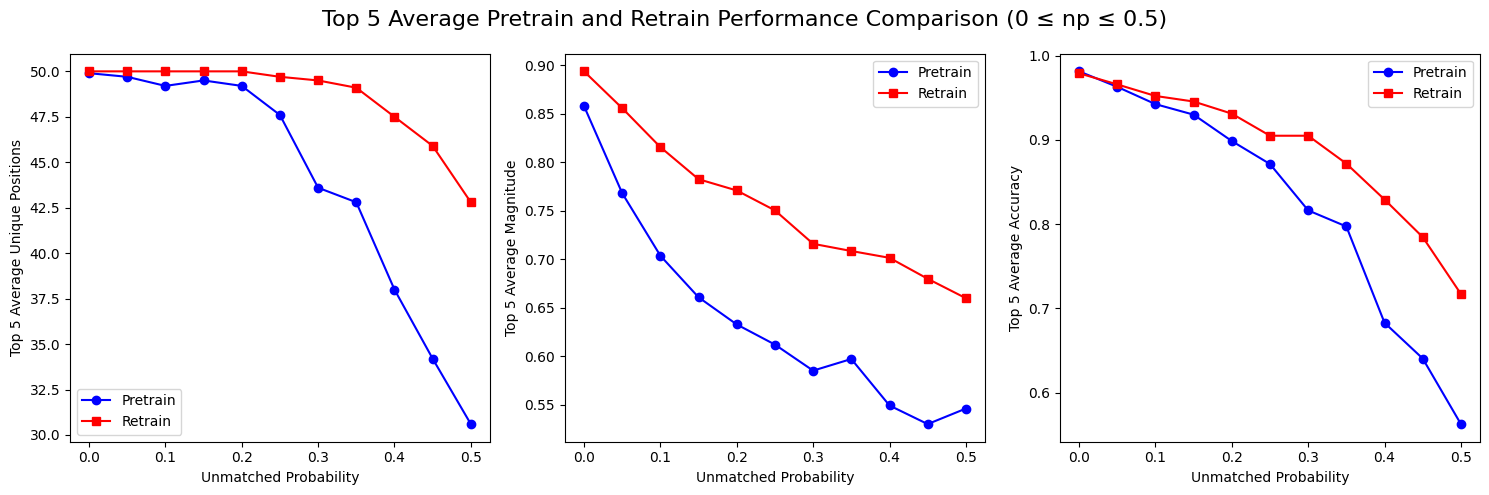

Noise Probabilities: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Top 5 Average Pretrain Accuracies: [0.9812, 0.9628, 0.9422999999999998, 0.9298000000000002, 0.8985, 0.8712, 0.8161999999999999, 0.7971000000000001, 0.6828, 0.6404000000000001, 0.5626]
Top 5 Average Retrain Accuracies: [0.9789, 0.9657, 0.952, 0.9453999999999999, 0.931, 0.9048000000000002, 0.9048, 0.8716999999999999, 0.8291000000000001, 0.7845000000000001, 0.717]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def safe_mean(data_list):
    if not data_list:
        return 0.0
    if isinstance(data_list[0], (int, float)):
        return np.mean(data_list)
    return np.mean([d for d in data_list if isinstance(d, (int, float))])

def calculate_top_5_averages(results, retrain_results):
    average_results = {'initial': {}, 'retrained': {}}
    t = 10
    for np in results:
        if 0 <= np <= 0.5:  # Only process noise probabilities between 0 and 0.5
            initial_data = [results[np][exp] for exp in results[np]]
            
            # Handle potential issues with retrain_results
            retrain_data = []
            for exp in retrain_results[np]:
                if isinstance(retrain_results[np][exp], list) and retrain_results[np][exp]:
                    retrain_data.append(retrain_results[np][exp][-1])  # Use the last iteration
                elif isinstance(retrain_results[np][exp], dict):
                    retrain_data.append(retrain_results[np][exp])  # It's already a single result
                else:
                    print(f"Warning: Unexpected data structure for np={np}, exp={exp}")
                    continue
            
            if not retrain_data:
                print(f"Warning: No valid retrain data for np={np}")
                continue
            
            # Sort and select top 5 for each metric
            top_5_unique = sorted(initial_data, key=lambda x: x['Unique_positions'], reverse=True)[:t]
            top_5_magnitude = sorted(initial_data, key=lambda x: x['Average_magnitude'], reverse=True)[:t]
            top_5_accuracy = sorted(initial_data, key=lambda x: x['linear_classifier_accuracy'], reverse=True)[:t]
            
            average_results['initial'][np] = {
                'Unique_positions': safe_mean([d['Unique_positions'] for d in top_5_unique]),
                'Average_magnitude': safe_mean([d['Average_magnitude'] for d in top_5_magnitude]),
                'linear_classifier_accuracy': safe_mean([d['linear_classifier_accuracy'] for d in top_5_accuracy])
            }
            
            # Repeat for retrained data
            top_5_unique = sorted(retrain_data, key=lambda x: x['Unique_positions'], reverse=True)[:t]
            top_5_magnitude = sorted(retrain_data, key=lambda x: x['Average_magnitude'], reverse=True)[:t]
            top_5_accuracy = sorted(retrain_data, key=lambda x: x['linear_classifier_accuracy'], reverse=True)[:t]
            
            average_results['retrained'][np] = {
                'Unique_positions': safe_mean([d['Unique_positions'] for d in top_5_unique]),
                'Average_magnitude': safe_mean([d['Average_magnitude'] for d in top_5_magnitude]),
                'linear_classifier_accuracy': safe_mean([d['linear_classifier_accuracy'] for d in top_5_accuracy])
            }
    
    return average_results

# Calculate top 5 averages
average_results = calculate_top_5_averages(results, retrain_results)

# Print detailed results
# for np in sorted(average_results['initial'].keys()):
#     print(f"\nDetailed top 5 average results for Noise Probability {np}:")
#     print("Initial Results:")
#     print(f"  Unique positions: {average_results['initial'][np]['Unique_positions']:.2f}")
#     print(f"  Average magnitude: {average_results['initial'][np]['Average_magnitude']:.4f}")
#     print(f"  Test Accuracy: {average_results['initial'][np]['linear_classifier_accuracy']:.4f}")
    
#     print("Retrained Results:")
#     print(f"  Unique positions: {average_results['retrained'][np]['Unique_positions']:.2f}")
#     print(f"  Average magnitude: {average_results['retrained'][np]['Average_magnitude']:.4f}")
#     print(f"  Test Accuracy: {average_results['retrained'][np]['linear_classifier_accuracy']:.4f}")

# Extract data for plotting
noise_probs = sorted(set(average_results['initial'].keys()) & set(average_results['retrained'].keys()))

pretrain_unique_positions = [average_results['initial'][np]['Unique_positions'] for np in noise_probs]
pretrain_avg_magnitudes = [average_results['initial'][np]['Average_magnitude'] for np in noise_probs]
pretrain_accuracies = [average_results['initial'][np]['linear_classifier_accuracy'] for np in noise_probs]

retrain_unique_positions = [average_results['retrained'][np]['Unique_positions'] for np in noise_probs]
retrain_avg_magnitudes = [average_results['retrained'][np]['Average_magnitude'] for np in noise_probs]
retrain_accuracies = [average_results['retrained'][np]['linear_classifier_accuracy'] for np in noise_probs]

# Create the plot with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Top 5 Average Pretrain and Retrain Performance Comparison (0 ≤ np ≤ 0.5)', fontsize=16)

# Unique Positions plot
axs[0].plot(noise_probs, pretrain_unique_positions, 'b-o', label='Pretrain')
axs[0].plot(noise_probs, retrain_unique_positions, 'r-s', label='Retrain')
axs[0].set_xlabel('Unmatched Probability')
axs[0].set_ylabel('Top 5 Average Unique Positions')
axs[0].legend()

# Average Magnitude plot
axs[1].plot(noise_probs, pretrain_avg_magnitudes, 'b-o', label='Pretrain')
axs[1].plot(noise_probs, retrain_avg_magnitudes, 'r-s', label='Retrain')
axs[1].set_xlabel('Unmatched Probability')
axs[1].set_ylabel('Top 5 Average Magnitude')
axs[1].legend()

# Accuracy plot
axs[2].plot(noise_probs, pretrain_accuracies, 'b-o', label='Pretrain')
axs[2].plot(noise_probs, retrain_accuracies, 'r-s', label='Retrain')
axs[2].set_xlabel('Unmatched Probability')
axs[2].set_ylabel('Top 5 Average Accuracy')
axs[2].legend()

plt.tight_layout()
plt.show()

# Print the data for verification
print("Noise Probabilities:", noise_probs)
print("Top 5 Average Pretrain Accuracies:", pretrain_accuracies)
print("Top 5 Average Retrain Accuracies:", retrain_accuracies)

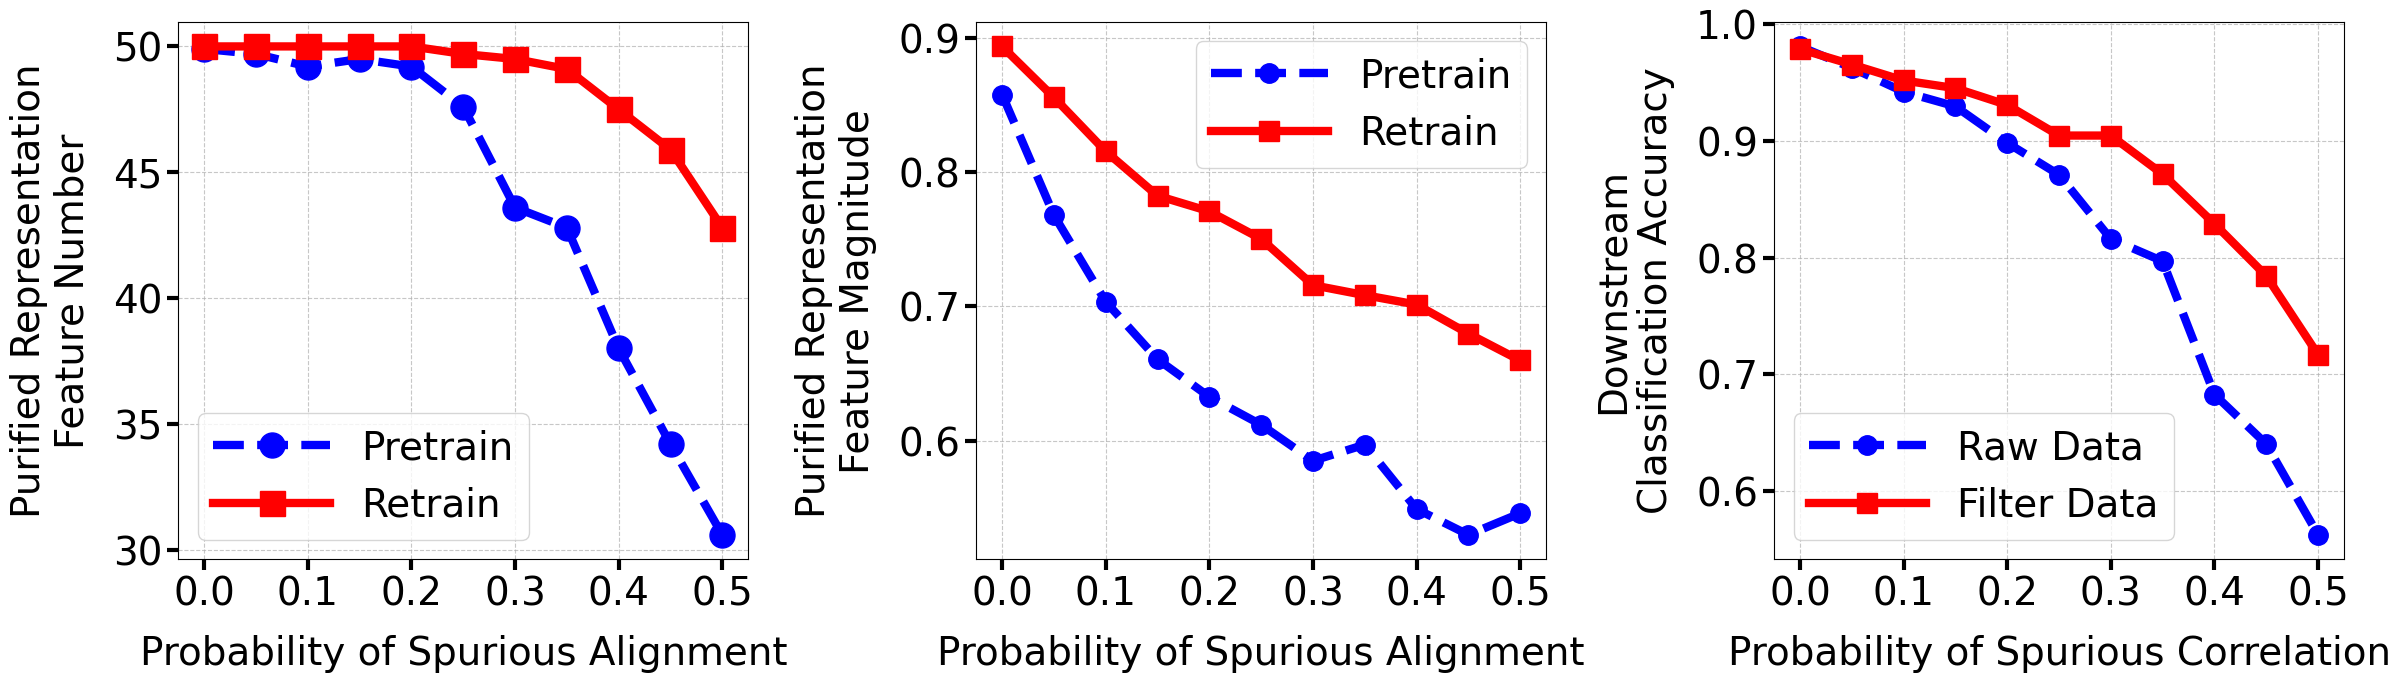

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set font sizes
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 28

# Create the plot with three subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
# fig.suptitle('Top 5 Average Pretrain and Retrain Performance Comparison\n(0 ≤ Spurious Aligned Probability ≤ 0.5)', 
#              fontsize=26, y=1.05)

# Average Purified Feature Count plot
axs[0].plot(noise_probs, pretrain_unique_positions, 'b--o', label='Pretrain', linewidth=6, markersize=18)
axs[0].plot(noise_probs, retrain_unique_positions, 'r-s', label='Retrain', linewidth=6, markersize=18)
axs[0].set_xlabel('Probability of Spurious Alignment', labelpad=15)
axs[0].set_ylabel('Purified Representation\nFeature Number', labelpad=15)
axs[0].legend(loc='lower left', frameon=True, handlelength=3)  # 增加 handlelength
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='both', which='major', length=8, width=3)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(5))

# Average Purified Feature Magnitude plot
axs[1].plot(noise_probs, pretrain_avg_magnitudes, 'b--o', label='Pretrain', linewidth=6, markersize=14)
axs[1].plot(noise_probs, retrain_avg_magnitudes, 'r-s', label='Retrain', linewidth=6, markersize=14)
axs[1].set_xlabel('Probability of Spurious Alignment', labelpad=15)
axs[1].set_ylabel('Purified Representation\nFeature Magnitude', labelpad=15)
axs[1].legend(loc='upper right', frameon=True, handlelength=3)  # 增加 handlelength
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='both', which='major', length=8, width=3)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))

# Average Downstream Classification Accuracy plot
axs[2].plot(noise_probs, pretrain_accuracies, 'b--o', label='Raw Data', linewidth=6, markersize=14)
axs[2].plot(noise_probs, retrain_accuracies, 'r-s', label='Filter Data', linewidth=6, markersize=14)
axs[2].set_xlabel('Probability of Spurious Correlation', labelpad=15)
axs[2].set_ylabel('Downstream\nClassification Accuracy', labelpad=15)
axs[2].legend(loc='lower left', frameon=True, handlelength=3)  # 增加 handlelength
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].tick_params(axis='both', which='major', length=8, width=3)
axs[2].yaxis.set_major_locator(plt.MultipleLocator(0.1))

# For all subplots, set x-axis ticks interval to 0.1
for ax in axs:
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4)

# Save the figure with high resolution
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create image directory if it doesn't exist
if not os.path.exists('image'):
    os.makedirs('image')

# Set font sizes
plt.rcParams['font.size'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 30

# Function to create and save individual plots
def create_single_plot(data_x, data_y1, data_y2, xlabel, ylabel, legend_loc, filename, y_interval):
    plt.figure(figsize=(10, 8))
    plt.plot(data_x, data_y1, 'b--o', label='Raw Data', linewidth=10, markersize=25)
    plt.plot(data_x, data_y2, 'r-s', label='Synthetic Data', linewidth=10, markersize=25)
    plt.xlabel('Probability of Spurious Correlation', labelpad=15)
    plt.ylabel(ylabel, labelpad=15)
    plt.legend(loc=legend_loc, frameon=True, handlelength=3)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', length=8, width=3)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(y_interval))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.tight_layout()
    plt.savefig(os.path.join('image', filename), dpi=300, bbox_inches='tight')
    plt.close()

# Create and save feature number plot
create_single_plot(
    noise_probs, 
    pretrain_unique_positions, 
    retrain_unique_positions,
    'Probability of Spurious Correlation',
    'Purified Feature Number',
    'lower left',
    'feature_number.png',
    5
)

# Create and save feature magnitude plot
create_single_plot(
    noise_probs, 
    pretrain_avg_magnitudes, 
    retrain_avg_magnitudes,
    'Probability of Spurious Correlation',
    'Purified Feature Magnitude',
    'upper right',
    'feature_magnitude.png',
    0.1
)

# Create and save classification accuracy plot
create_single_plot(
    noise_probs, 
    pretrain_accuracies, 
    retrain_accuracies,
    'Probability of Spurious Correlation',
    'Classification Accuracy',
    'lower left',
    'classification_accuracy.png',
    0.1
)

In [9]:
M = results[0][0]['M']
H = results[0][0]['H']

Performing 2D t-SNE...


/home/sunj11/anaconda3/envs/ogbn-arxiv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/sunj11/anaconda3/envs/ogbn-arxiv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/sunj11/anaconda3/envs/ogbn-arxiv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/sunj11/anaconda3/envs/ogbn-arxiv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: F

Text(0.5, 1.0, 'Retrained Feature Representation Visualization')

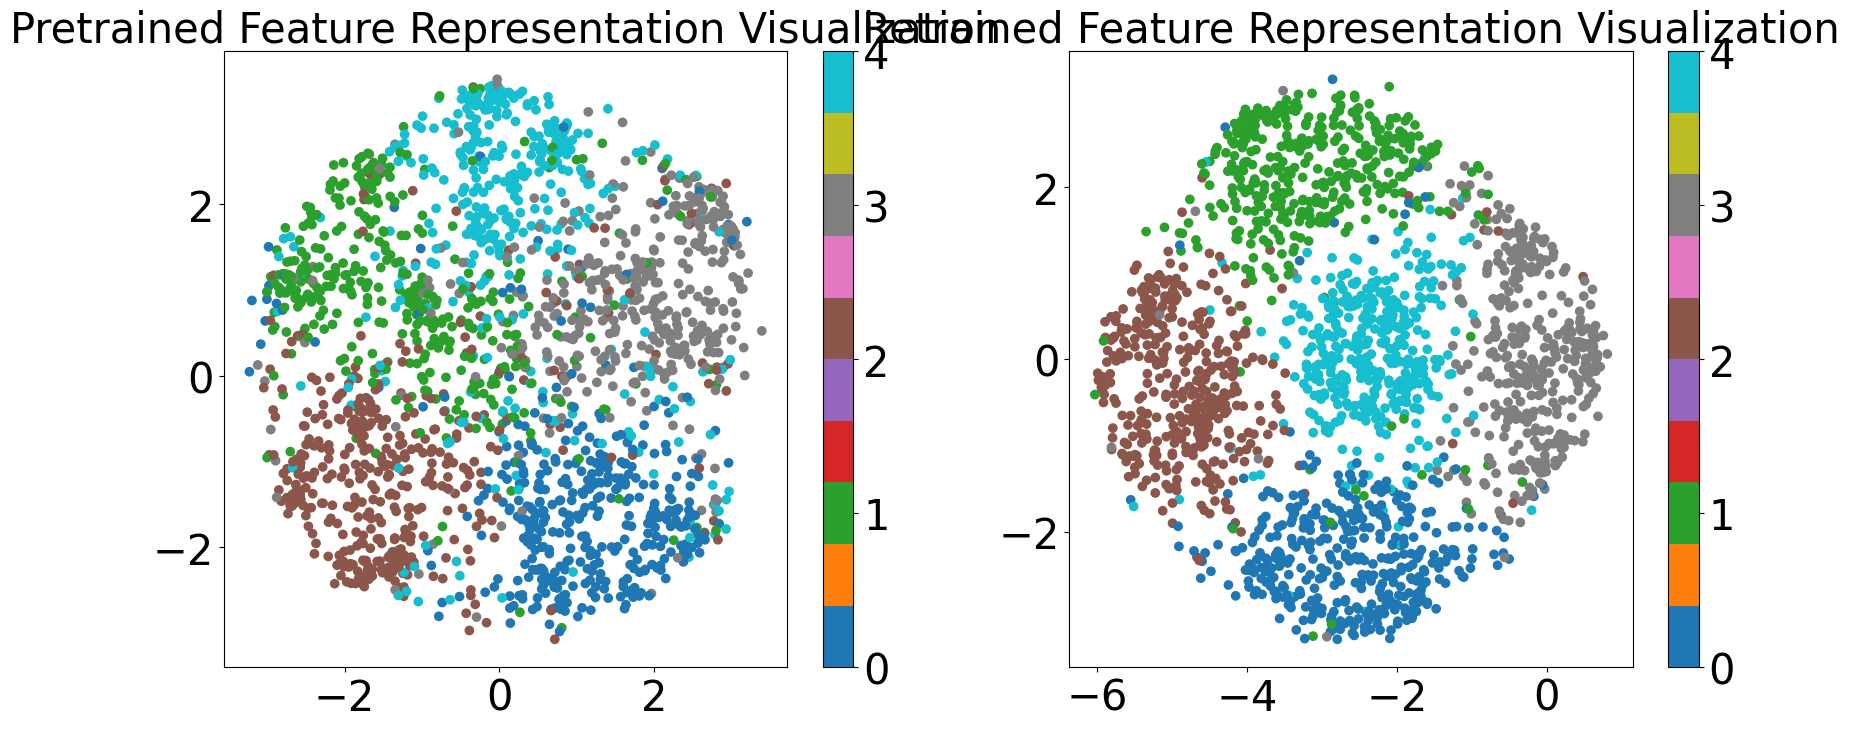

In [12]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设您已经有了 results 和 retrain_results


# 提取特征
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
downstream_total_samples = 10000
num_classes = 5

def extract_image_features(test_loader, image_encoder, device):
    image_features_list = []
    labels_list = []
    
    image_encoder.eval()
    with torch.no_grad():
        for x, _, _, one_hot in test_loader:
            x = x.to(device)
            image_features = image_encoder(x)
            image_features_list.append(image_features.cpu().numpy())
            labels_list.append(torch.argmax(one_hot, dim=1).cpu().numpy())
    
    return np.concatenate(image_features_list, axis=0), np.concatenate(labels_list, axis=0)

def select_rank_encoder(results, p, rank=None):
    # 获取所有实验的准确率
    accuracies = [exp['linear_classifier_accuracy'] for exp in results[p].values()]
    sorted_accuracies = sorted(accuracies, reverse=True)  # 降序排列
    
    # 如果没有指定 rank，则默认选择中位数
    if rank is None:
        rank = len(accuracies) // 2
    
    # 确保 rank 在有效范围内
    rank = max(0, min(rank, len(accuracies) - 1))
    
    # 获取指定顺位的准确率
    target_accuracy = sorted_accuracies[rank]
    
    # 找到对应指定准确率的实验
    for exp, data in results[p].items():
        if data['linear_classifier_accuracy'] == target_accuracy:
            return data['image_encoder']
    
    # 如果没有找到完全匹配的，返回最接近指定顺位的
    closest_exp = min(results[p].items(), key=lambda x: abs(x[1]['linear_classifier_accuracy'] - target_accuracy))
    return closest_exp[1]['image_encoder']

# 创建数据集
text_data = create_Text_dataset(H, d1, d, sigma_xi, num_classes)
_, downstream_test_loader = create_dataset(downstream_total_samples, M, d1, d, sigma_xi, num_classes, batch_size=B)


# 选择中位数性能的 encoder
p = 0.3  # 选择要分析的概率
image_encoder_results = select_rank_encoder(results, p, rank=10)
# image_encoder_results = select_best_encoder(results, results, p)[0].to(device)
image_encoder_retrain = select_rank_encoder(retrain_results, p, rank=10)
# image_encoder_retrain = select_best_encoder(retrain_results, retrain_results, p)[0].to(device)

# 提取 results 中的特征
image_features_results, labels = extract_image_features(downstream_test_loader, image_encoder_results, device)

# 提取 retrain_results 中的特征
image_features_retrain, labels_retrain = extract_image_features(downstream_test_loader, image_encoder_retrain, device)

# 执行 t-SNE
print("Performing 2D t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=500, metric='cosine')
image_features_tsne_results = tsne_2d.fit_transform(image_features_results)
image_features_tsne_retrain = tsne_2d.fit_transform(image_features_retrain)

# 绘图
plt.figure(figsize=(20, 8))

# results 的图像特征
plt.subplot(121)
scatter = plt.scatter(image_features_tsne_results[:, 0], image_features_tsne_results[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter)
plt.title(f'Pretrained Feature Representation Visualization')

# retrain_results 的图像特征
plt.subplot(122)
scatter = plt.scatter(image_features_tsne_retrain[:, 0], image_features_tsne_retrain[:, 1], c=labels_retrain, cmap='tab10')
plt.colorbar(scatter)
plt.title(f'Retrained Feature Representation Visualization')


In [13]:
# 创建image文件夹（如果不存在）
import os
if not os.path.exists('image'):
    os.makedirs('image')

# 绘制并保存第一个图（Pretrained）
plt.figure(figsize=(8, 8))
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

scatter = plt.scatter(image_features_tsne_results[:, 0], image_features_tsne_results[:, 1], c=labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), loc='lower right', prop={'size': 10})
# plt.title(f'Pretrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
plt.savefig('image/pretrained_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

# 绘制并保存第二个图（Retrained）
plt.figure(figsize=(8, 8))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

scatter = plt.scatter(image_features_tsne_retrain[:, 0], image_features_tsne_retrain[:, 1], c=labels_retrain, cmap='tab10')
plt.legend(*scatter.legend_elements(), loc='lower right', prop={'size': 10})
# plt.title(f'Retrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
plt.savefig('image/retrained_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

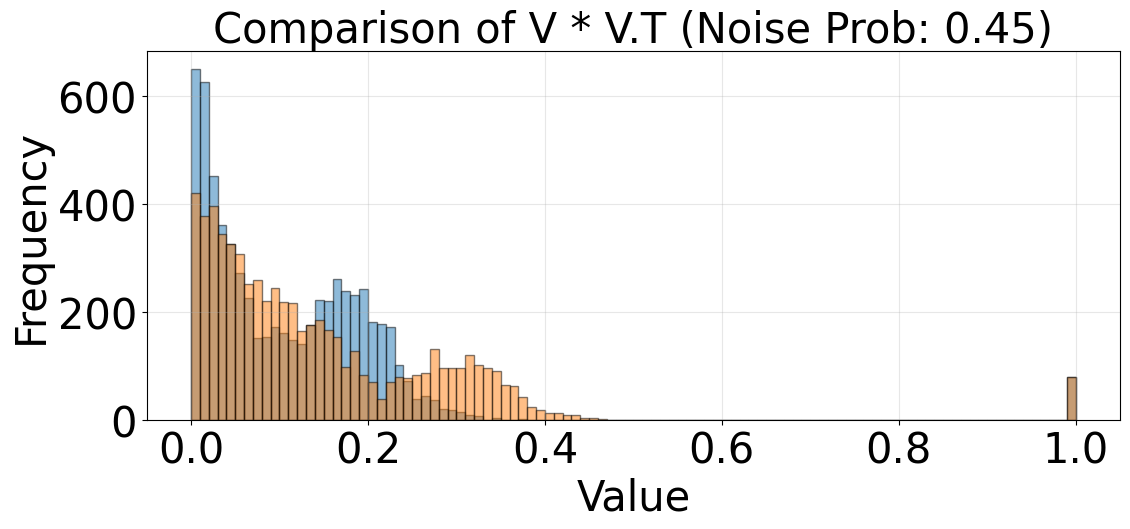

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def select_rank_encoder(results, p, rank=None):
    # 获取所有实验的准确率
    accuracies = [exp['linear_classifier_accuracy'] for exp in results[p].values()]
    sorted_accuracies = sorted(accuracies, reverse=True)  # 降序排列
    
    # 如果没有指定 rank，则默认选择中位数
    if rank is None:
        rank = len(accuracies) // 2
    
    # 确保 rank 在有效范围内
    rank = max(0, min(rank, len(accuracies) - 1))
    
    # 获取指定顺位的准确率
    target_accuracy = sorted_accuracies[rank]
    
    # 找到对应指定准确率的实验
    for exp, data in results[p].items():
        if data['linear_classifier_accuracy'] == target_accuracy:
            return data['image_encoder']
    
    # 如果没有找到完全匹配的，返回最接近指定顺位的
    closest_exp = min(results[p].items(), key=lambda x: abs(x[1]['linear_classifier_accuracy'] - target_accuracy))
    return closest_exp[1]['image_encoder']


def plot_compare_vvt_histograms(V_pretrained, V_retrained, np_value, bins=100, threshold=0):
    # 计算 V * V.T
    VVT_pretrained = torch.matmul(V_pretrained, V_pretrained.T)
    VVT_retrained = torch.matmul(V_retrained, V_retrained.T)
    
    # 转换为 numpy 数组并展平
    VVT_flat_pretrained = np.abs(VVT_pretrained.cpu().detach().numpy().flatten())
    VVT_flat_retrained = np.abs(VVT_retrained.cpu().detach().numpy().flatten())
    
    # 过滤小于阈值的值
    VVT_flat_pretrained = VVT_flat_pretrained[VVT_flat_pretrained > threshold]
    VVT_flat_retrained = VVT_flat_retrained[VVT_flat_retrained > threshold]
    
    # 计算均值和方差
    mean_pretrained = np.mean(VVT_flat_pretrained)
    var_pretrained = np.var(VVT_flat_pretrained)
    mean_retrained = np.mean(VVT_flat_retrained)
    var_retrained = np.var(VVT_flat_retrained)
    
    # 确定 x 轴和 y 轴的范围
    x_min = min(VVT_flat_pretrained.min(), VVT_flat_retrained.min())
    x_max = max(VVT_flat_pretrained.max(), VVT_flat_retrained.max())
    
    # 创建直方图
    plt.figure(figsize=(12, 6))
    
    # 绘制预训练的直方图
    plt.hist(VVT_flat_pretrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Pretrained', edgecolor='black')
    
    # 绘制重训练的直方图
    plt.hist(VVT_flat_retrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Retrained', edgecolor='black')
    
    # 设置图表标题和轴标签
    plt.title(f"Comparison of V * V.T (Noise Prob: {np_value})")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # # 添加均值和方差信息到图例
    # plt.legend([f'Pretrained (Mean: {mean_pretrained:.4f}, Var: {var_pretrained:.4f})',
    #             f'Retrained (Mean: {mean_retrained:.4f}, Var: {var_retrained:.4f})'])
    
    # 显示网格
    plt.grid(True, alpha=0.3)
    
    # 显示图表
    plt.tight_layout()
    plt.show()
    
    # # 打印均值和方差
    # print(f"Pretrained - Mean: {mean_pretrained:.4f}, Variance: {var_pretrained:.4f}")
    # print(f"Retrained - Mean: {mean_retrained:.4f}, Variance: {var_retrained:.4f}")

# 选择中位数性能的 encoder
p = 0.45  # 选择要分析的概率
image_encoder_results = select_rank_encoder(results, p, rank=5)
# image_encoder_results = select_best_encoder(results, results, p)[0].to(device)
image_encoder_retrain = select_rank_encoder(retrain_results, p, rank=5)
# image_encoder_retrain = select_best_encoder(retrain_results, retrain_results, p)[0].to(device)

V_pretrained = image_encoder_results.linear1.weight.data.clone()
V_retrained = image_encoder_retrain.linear1.weight.data.clone()

plot_compare_vvt_histograms(V_pretrained, V_retrained, p, threshold=0)

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def select_rank_encoder(results, p, rank=None):
    # 获取所有实验的准确率
    accuracies = [exp['linear_classifier_accuracy'] for exp in results[p].values()]
    sorted_accuracies = sorted(accuracies, reverse=True)  # 降序排列
    
    # 如果没有指定 rank，则默认选择中位数
    if rank is None:
        rank = len(accuracies) // 2
    
    # 确保 rank 在有效范围内
    rank = max(0, min(rank, len(accuracies) - 1))
    
    # 获取指定顺位的准确率
    target_accuracy = sorted_accuracies[rank]
    
    # 找到对应指定准确率的实验
    for exp, data in results[p].items():
        if data['linear_classifier_accuracy'] == target_accuracy:
            return data['text_encoder']
    
    # 如果没有找到完全匹配的，返回最接近指定顺位的
    closest_exp = min(results[p].items(), key=lambda x: abs(x[1]['linear_classifier_accuracy'] - target_accuracy))
    return closest_exp[1]['text_encoder']


def plot_compare_vht_histograms(V_pretrained, V_retrained, np_value, bins=100, threshold=0):
    # 计算 V * V.T
    # VVT_pretrained = torch.matmul(V_pretrained, V_pretrained.T)
    # VVT_retrained = torch.matmul(V_retrained, V_retrained.T)
    VVT_pretrained = torch.matmul(V_pretrained, H.to(device) )
    VVT_retrained = torch.matmul(V_retrained, H.to(device))
    # 转换为 numpy 数组并展平
    # VVT_flat_pretrained = VVT_pretrained.cpu().detach().numpy().flatten()
    # VVT_flat_retrained = VVT_retrained.cpu().detach().numpy().flatten()
    VVT_flat_pretrained = np.abs(VVT_pretrained.cpu().detach().numpy().flatten())
    VVT_flat_retrained = np.abs(VVT_retrained.cpu().detach().numpy().flatten())
    
    # 过滤小于阈值的值
    VVT_flat_pretrained = VVT_flat_pretrained[VVT_flat_pretrained > threshold]
    VVT_flat_retrained = VVT_flat_retrained[VVT_flat_retrained > threshold]
    
    # 确定 x 轴和 y 轴的范围
    x_min = min(VVT_flat_pretrained.min(), VVT_flat_retrained.min())
    x_max = max(VVT_flat_pretrained.max(), VVT_flat_retrained.max())
    
    # 创建直方图
    plt.figure(figsize=(12, 6))
    
    # 绘制预训练的直方图
    plt.hist(VVT_flat_pretrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Pretrain', edgecolor='black')
    
    # 绘制重训练的直方图
    plt.hist(VVT_flat_retrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Retrain', edgecolor='black')
    
    # 设置图表标题和轴标签
    plt.title(f"Comparison of V * V.T (Noise Prob: {np_value})")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # 添加简单的图例
    plt.legend()
    
    # 显示网格
    plt.grid(True, alpha=0.3)
    
    # 显示图表
    plt.tight_layout()
    plt.show()

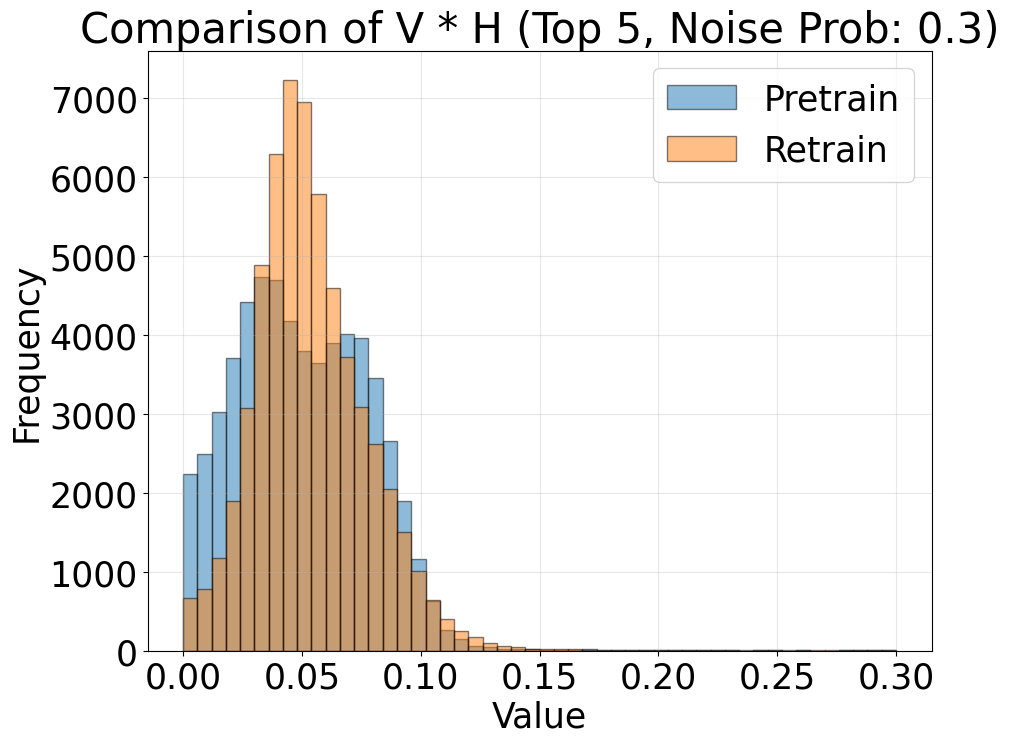

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def select_top_k_encoders(results, p, k=5):
    experiments = list(results[p].items())
    sorted_experiments = sorted(experiments, key=lambda x: x[1]['linear_classifier_accuracy'], reverse=True)
    return [exp[1]['text_encoder'] for exp in sorted_experiments[:k]]

def plot_compare_vht_histograms(pretrain_encoders, retrain_encoders, np_value, bins=50, threshold=0):
    # 计算和收集值的部分保持不变...
    pretrain_values = []
    for encoder in pretrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        values = values[values > threshold]
        pretrain_values.extend(values)
    
    retrain_values = []
    for encoder in retrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        values = values[values > threshold]
        retrain_values.extend(values)
    
    x_min = min(min(pretrain_values), min(retrain_values))
    x_max = max(max(pretrain_values), max(retrain_values))
    x_max = 0.3
    
    # 创建图形并设置字体大小
    plt.figure(figsize=(10, 8))
    
    # 设置全局字体大小
    plt.rcParams['font.size'] = 25
    plt.rcParams['axes.labelsize'] = 25
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    plt.rcParams['legend.fontsize'] = 25
    
    # 绘制直方图
    plt.hist(pretrain_values, bins=bins, range=(x_min, x_max), alpha=0.5, label='Pretrain', edgecolor='black')
    plt.hist(retrain_values, bins=bins, range=(x_min, x_max), alpha=0.5, label='Retrain', edgecolor='black')
    
    plt.title(f"Comparison of V * H (Top 5, Noise Prob: {np_value})")
    plt.xlabel('Value', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.legend(prop={'size': 25})  # 设置图例字体大小
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 使用示例
p = 0.30  # 选择要分析的概率

# 获取前5个encoder
top_5_pretrain = select_top_k_encoders(results, p, k=15)
top_5_retrain = select_top_k_encoders(retrain_results, p, k=15)

# 绘制直方图
plot_compare_vht_histograms(top_5_pretrain, top_5_retrain, p, threshold=0)

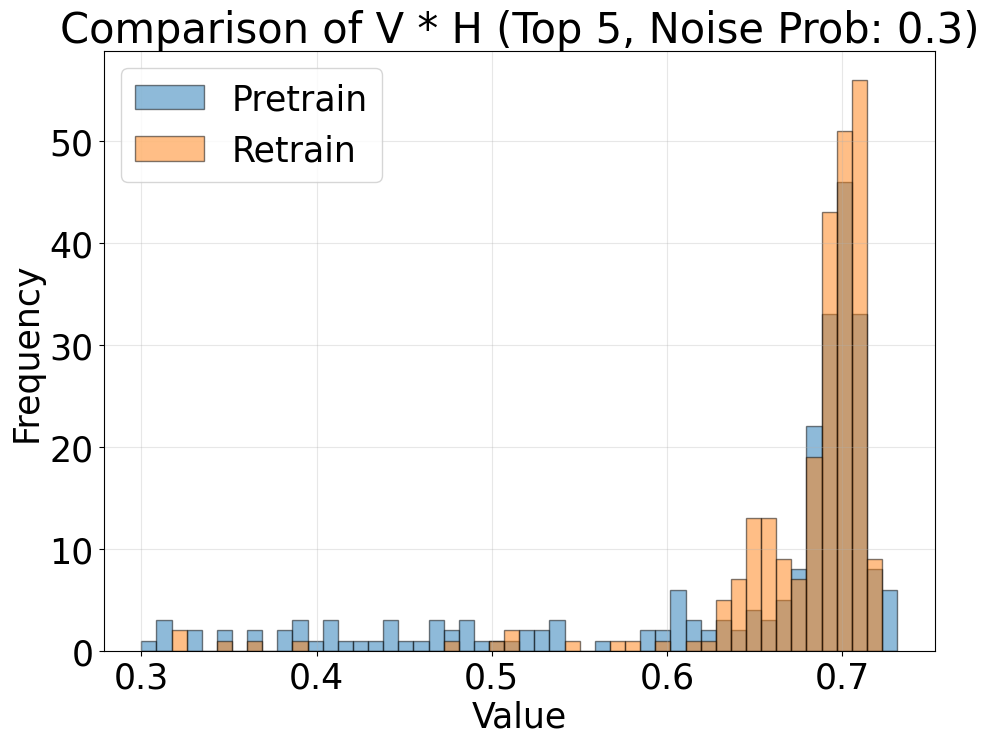

In [12]:
def select_top_k_encoders(results, p, k=5):
    experiments = list(results[p].items())
    sorted_experiments = sorted(experiments, key=lambda x: x[1]['linear_classifier_accuracy'], reverse=True)
    return [exp[1]['text_encoder'] for exp in sorted_experiments[:k]]

def plot_compare_vht_histograms(pretrain_encoders, retrain_encoders, np_value, bins=50, threshold=0):
    # 计算和收集值的部分保持不变...
    pretrain_values = []
    for encoder in pretrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        values = values[values > threshold]
        pretrain_values.extend(values)
    
    retrain_values = []
    for encoder in retrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        values = values[values > threshold]
        retrain_values.extend(values)
    
    x_min = min(min(pretrain_values), min(retrain_values))
    x_max = max(max(pretrain_values), max(retrain_values))
    x_min = 0.3
    
    # 创建图形并设置字体大小
    plt.figure(figsize=(10, 8))
    
    # 设置全局字体大小
    plt.rcParams['font.size'] = 25
    plt.rcParams['axes.labelsize'] = 25
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    plt.rcParams['legend.fontsize'] = 25
    
    # 绘制直方图
    plt.hist(pretrain_values, bins=bins, range=(x_min, x_max), alpha=0.5, label='Pretrain', edgecolor='black')
    plt.hist(retrain_values, bins=bins, range=(x_min, x_max), alpha=0.5, label='Retrain', edgecolor='black')
    
    plt.title(f"Comparison of V * H (Top 5, Noise Prob: {np_value})")
    plt.xlabel('Value', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    plt.legend(prop={'size': 25})  # 设置图例字体大小
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 使用示例
p = 0.3  # 选择要分析的概率

# 获取前5个encoder
top_5_pretrain = select_top_k_encoders(results, p, k=5)
top_5_retrain = select_top_k_encoders(retrain_results, p, k=5)

# 绘制直方图
plot_compare_vht_histograms(top_5_pretrain, top_5_retrain, p, threshold=0)

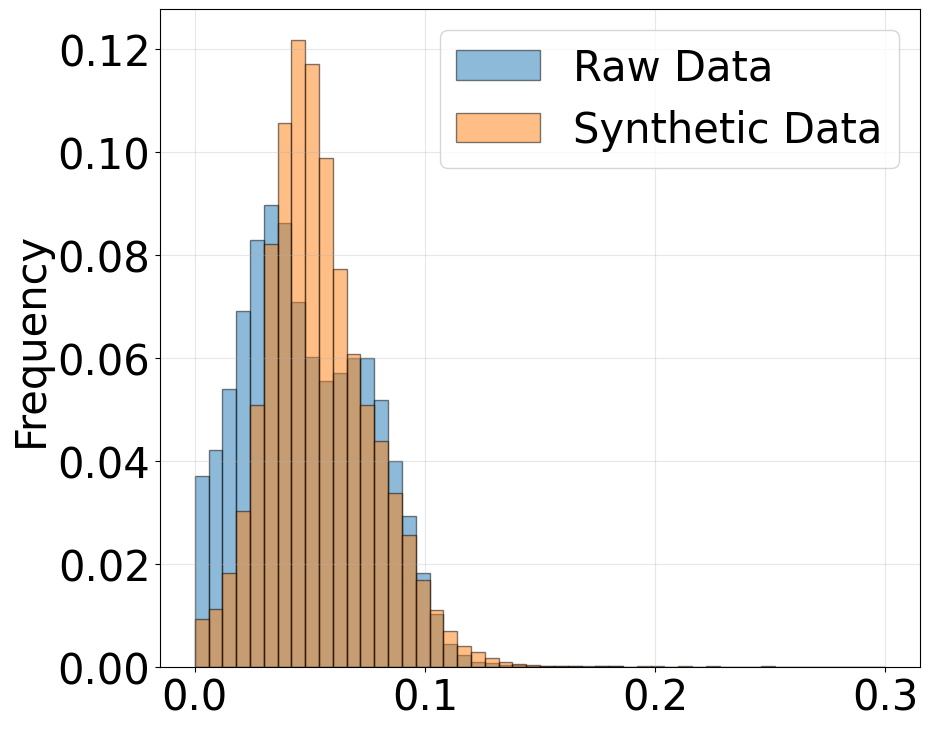

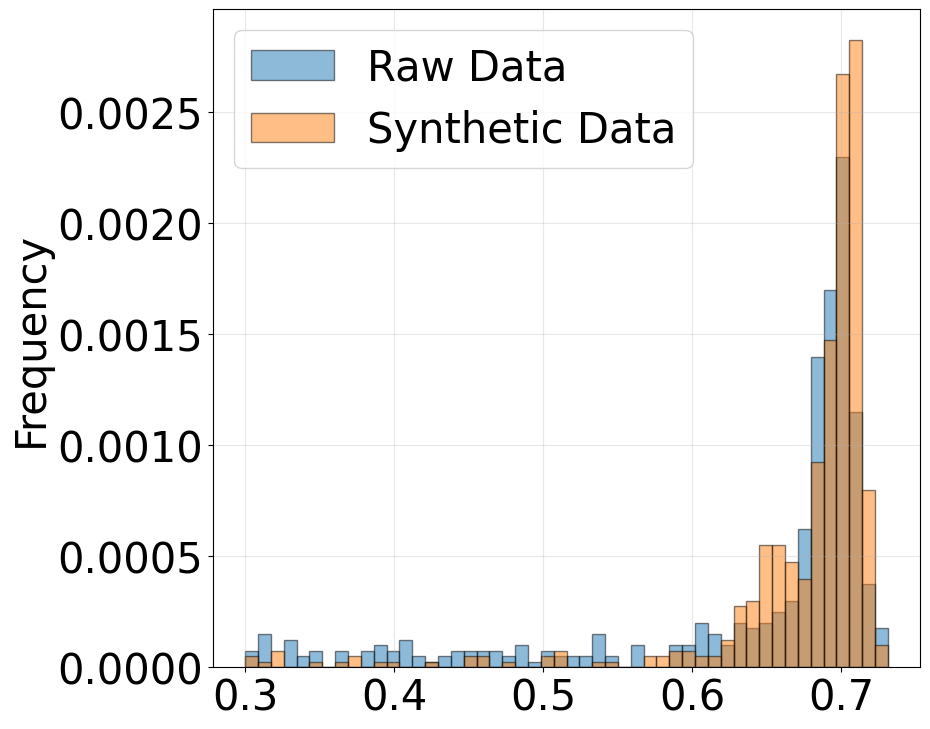

In [14]:
def plot_vht_histogram_range(pretrain_encoders, retrain_encoders, np_value, range_min, range_max, bins=50):
    # 计算值
    pretrain_values = []
    for encoder in pretrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        pretrain_values.extend(values)
    
    retrain_values = []
    for encoder in retrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VH = torch.matmul(V, H.to(device))
        values = np.abs(VH.cpu().detach().numpy().flatten())
        retrain_values.extend(values)

    # 先计算概率分布
    weights_pretrain = np.ones_like(pretrain_values) / len(pretrain_values)
    weights_retrain = np.ones_like(retrain_values) / len(retrain_values)

    # 再筛选指定范围的值
    if range_max is None:
        pretrain_filtered = np.array([x for x in pretrain_values if x > range_min])
        weights_pretrain_filtered = np.array([w for x, w in zip(pretrain_values, weights_pretrain) if x > range_min])
        
        retrain_filtered = np.array([x for x in retrain_values if x > range_min])
        weights_retrain_filtered = np.array([w for x, w in zip(retrain_values, weights_retrain) if x > range_min])
        
        range_max = max(max(pretrain_filtered), max(retrain_filtered))
    else:
        pretrain_filtered = np.array([x for x in pretrain_values if range_min <= x <= range_max])
        weights_pretrain_filtered = np.array([w for x, w in zip(pretrain_values, weights_pretrain) if range_min <= x <= range_max])
        
        retrain_filtered = np.array([x for x in retrain_values if range_min <= x <= range_max])
        weights_retrain_filtered = np.array([w for x, w in zip(retrain_values, weights_retrain) if range_min <= x <= range_max])
    
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 设置字体大小
    plt.rcParams['font.size'] = 30
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['legend.fontsize'] = 30
    
    # 绘制直方图，使用筛选后的值和对应的权重
    plt.hist(pretrain_filtered, bins=bins, range=(range_min, range_max), 
            weights=weights_pretrain_filtered, alpha=0.5, label='Raw Data', edgecolor='black')
    plt.hist(retrain_filtered, bins=bins, range=(range_min, range_max), 
            weights=weights_retrain_filtered, alpha=0.5, label='Synthetic Data', edgecolor='black')
    
    range_desc = "≤ 0.3" if range_max <= 0.3 else "> 0.3"
    # plt.xlabel('Value of Elements in V·H', fontsize=25)
    plt.ylabel('Frequency', fontsize=30)
    plt.legend(prop={'size': 30})
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 保存图片
    import os
    if not os.path.exists('image'):
        os.makedirs('image')
    filename = f'vh_histogram_{"small" if range_max <= 0.3 else "large"}_noise_{np_value}.png'
    plt.savefig(f'image/{filename}', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    
def select_top_k_encoders(results, p, k=5):
   experiments = list(results[p].items())
   sorted_experiments = sorted(experiments, key=lambda x: x[1]['linear_classifier_accuracy'], reverse=True)
   return [exp[1]['text_encoder'] for exp in sorted_experiments[:k]]

# 使用示例
p = 0.3
top_5_pretrain = select_top_k_encoders(results, p, k=10)
top_5_retrain = select_top_k_encoders(retrain_results, p, k=10)

# 分别绘制两个范围的直方图
plot_vht_histogram_range(top_5_pretrain, top_5_retrain, p, 0.0, 0.3)  # 小于等于0.3的部分
plot_vht_histogram_range(top_5_pretrain, top_5_retrain, p, 0.3, None)  # 大于0.3的部分

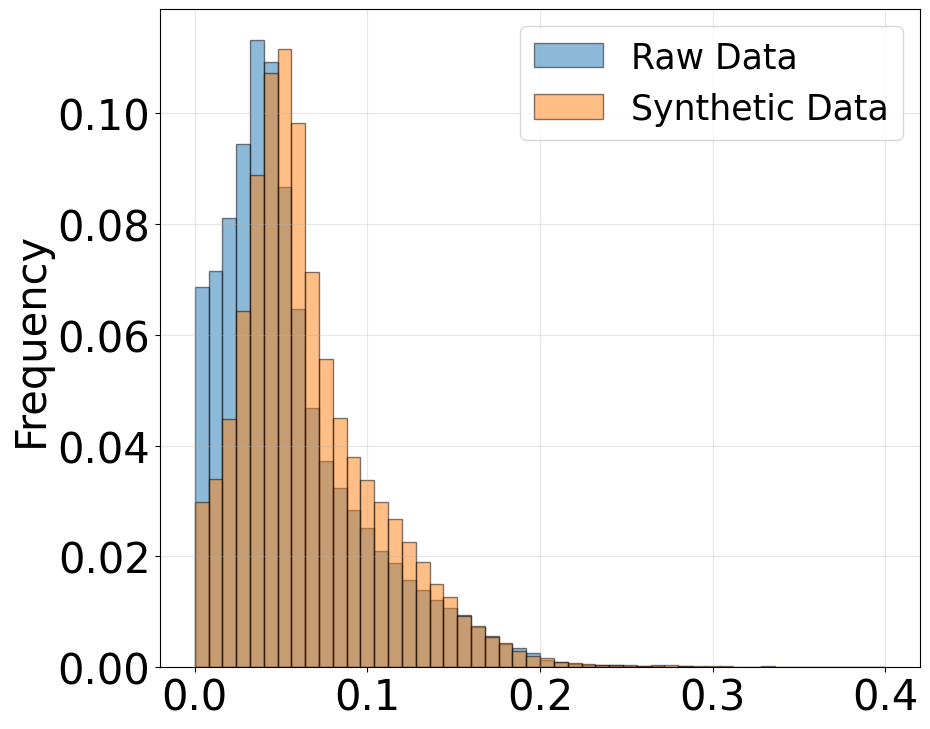

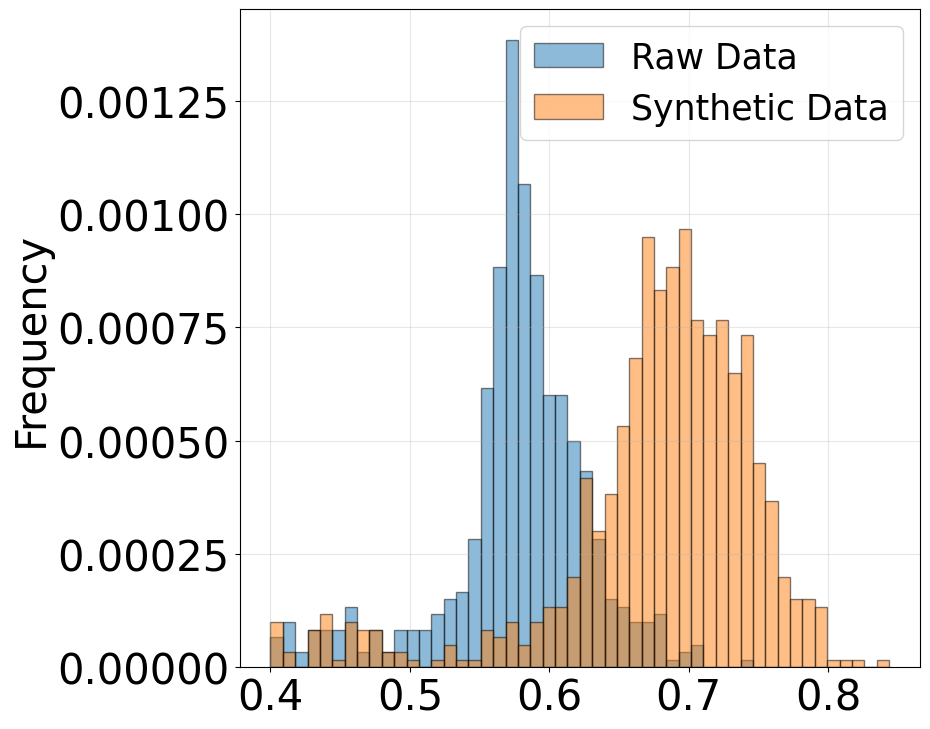

In [15]:
# def plot_wm_histogram_range(pretrain_encoders, retrain_encoders, np_value, range_min, range_max, bins=50):
#    # 计算值
#    pretrain_values = []
#    for encoder in pretrain_encoders:
#        V = encoder.linear1.weight.data.clone()
#        VW = torch.matmul(V, M.to(device))
#        values = np.abs(VW.cpu().detach().numpy().flatten())
#        pretrain_values.extend(values)
   
#    retrain_values = []
#    for encoder in retrain_encoders:
#        V = encoder.linear1.weight.data.clone()
#        VW = torch.matmul(V, M.to(device))
#        values = np.abs(VW.cpu().detach().numpy().flatten())
#        retrain_values.extend(values)

#    # 筛选指定范围的值
#    if range_max is None:
#        pretrain_filtered = np.array([x for x in pretrain_values if x > range_min])
#        retrain_filtered = np.array([x for x in retrain_values if x > range_min])
#        range_max = max(max(pretrain_filtered), max(retrain_filtered))
#    else:
#        pretrain_filtered = np.array([x for x in pretrain_values if range_min <= x <= range_max])
#        retrain_filtered = np.array([x for x in retrain_values if range_min <= x <= range_max])
   
#    # 计算权重(概率)而不是频数
#    weights_pretrain = np.ones_like(pretrain_filtered) / len(pretrain_filtered)
#    weights_retrain = np.ones_like(retrain_filtered) / len(retrain_filtered)
   
#    # 创建图形
#    plt.figure(figsize=(10, 8))
   
#    # 设置字体大小
#    plt.rcParams['font.size'] = 25
#    plt.rcParams['axes.labelsize'] = 25
#    plt.rcParams['xtick.labelsize'] = 25
#    plt.rcParams['ytick.labelsize'] = 25
#    plt.rcParams['legend.fontsize'] = 25
   
#    # 绘制直方图，使用weights参数来显示概率而不是频数
#    plt.hist(pretrain_filtered, bins=bins, range=(range_min, range_max), weights=weights_pretrain,
#            alpha=0.5, label='Raw Data', edgecolor='black')
#    plt.hist(retrain_filtered, bins=bins, range=(range_min, range_max), weights=weights_retrain,
#            alpha=0.5, label='Filtered Data', edgecolor='black')
   
#    range_desc = "≤ 0.4" if range_max <= 0.4 else "> 0.4"
#    plt.xlabel('Value of Elements in W·M', fontsize=25)
#    plt.ylabel('Probability', fontsize=25)  # 改为Probability
#    plt.legend(prop={'size': 25})
#    plt.grid(True, alpha=0.3)
#    plt.tight_layout()
#    plt.show()
   
#    # 保存图片
#    import os
#    if not os.path.exists('image'):
#        os.makedirs('image')
#    filename = f'wm_histogram_{"small" if range_max <= 0.4 else "large"}_noise_{np_value}.png'
#    plt.savefig(f'image/{filename}', dpi=300, bbox_inches='tight')
#    plt.close()
 

def plot_wm_histogram_range(pretrain_encoders, retrain_encoders, np_value, range_min, range_max, bins=50):
    # 计算值
    pretrain_values = []
    for encoder in pretrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VW = torch.matmul(V, M.to(device))
        values = np.abs(VW.cpu().detach().numpy().flatten())
        pretrain_values.extend(values)
    
    retrain_values = []
    for encoder in retrain_encoders:
        V = encoder.linear1.weight.data.clone()
        VW = torch.matmul(V, M.to(device))
        values = np.abs(VW.cpu().detach().numpy().flatten())
        retrain_values.extend(values)

    # 先计算概率分布
    weights_pretrain = np.ones_like(pretrain_values) / len(pretrain_values)
    weights_retrain = np.ones_like(retrain_values) / len(retrain_values)

    # 再筛选指定范围的值
    if range_max is None:
        pretrain_filtered = np.array([x for x in pretrain_values if x > range_min])
        weights_pretrain_filtered = np.array([w for x, w in zip(pretrain_values, weights_pretrain) if x > range_min])
        
        retrain_filtered = np.array([x for x in retrain_values if x > range_min])
        weights_retrain_filtered = np.array([w for x, w in zip(retrain_values, weights_retrain) if x > range_min])
        
        range_max = max(max(pretrain_filtered), max(retrain_filtered))
    else:
        pretrain_filtered = np.array([x for x in pretrain_values if range_min <= x <= range_max])
        weights_pretrain_filtered = np.array([w for x, w in zip(pretrain_values, weights_pretrain) if range_min <= x <= range_max])
        
        retrain_filtered = np.array([x for x in retrain_values if range_min <= x <= range_max])
        weights_retrain_filtered = np.array([w for x, w in zip(retrain_values, weights_retrain) if range_min <= x <= range_max])
    
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 设置字体大小
    plt.rcParams['font.size'] = 30
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['legend.fontsize'] = 30
    
    # 绘制直方图，使用筛选后的值和对应的权重
    plt.hist(pretrain_filtered, bins=bins, range=(range_min, range_max), 
            weights=weights_pretrain_filtered, alpha=0.5, label='Raw Data', edgecolor='black')
    plt.hist(retrain_filtered, bins=bins, range=(range_min, range_max), 
            weights=weights_retrain_filtered, alpha=0.5, label='Synthetic Data', edgecolor='black')
    
    range_desc = "≤ 0.3" if range_max <= 0.3 else "> 0.3"
    # plt.xlabel('Value of Elements in W·M', fontsize=25)
    plt.ylabel('Frequency', fontsize=30)
    plt.legend(prop={'size': 25})
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 保存图片
    import os
    if not os.path.exists('image'):
        os.makedirs('image')
    filename = f'wm_histogram_{"small" if range_max <= 0.4 else "large"}_noise_{np_value}.png'
    plt.savefig(f'image/{filename}', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def select_top_k_encoders(results, p, k=5):
    experiments = list(results[p].items())
    sorted_experiments = sorted(experiments, key=lambda x: x[1]['linear_classifier_accuracy'], reverse=True)
    return [exp[1]['image_encoder'] for exp in sorted_experiments[:k]]

# 使用示例
p = 0.3
top_5_pretrain = select_top_k_encoders(results, p, k=15)
top_5_retrain = select_top_k_encoders(retrain_results, p, k=15)

# 分别绘制两个范围的直方图
plot_wm_histogram_range(top_5_pretrain, top_5_retrain, p, 0, 0.4)  # 小于等于0.3的部分
plot_wm_histogram_range(top_5_pretrain, top_5_retrain, p, 0.4, None)  # 大于0.3的部分

In [73]:
VVT_pretrained = torch.matmul(V_pretrained, H.to(device) )

In [ ]:
def select_top_k_encoders(results, p, k=5):
    # 获取所有实验的准确率
    experiments = list(results[p].items())
    # 按准确率排序
    sorted_experiments = sorted(experiments, key=lambda x: x[1]['linear_classifier_accuracy'], reverse=True)
    
    # 获取前k个encoder并返回
    top_k_encoders = []
    for i in range(k):
        if i < len(sorted_experiments):
            top_k_encoders.append(sorted_experiments[i][1]['image_encoder'])
    return top_k_encoders

def plot_compare_vht_histograms(V_pretrained_list, V_retrained_list, np_value, bins=100, threshold=0):
    # 计算每个encoder的 V * H 并取平均
    VH_pretrained_list = []
    VH_retrained_list = []
    
    for V_pre in V_pretrained_list:
        vh = torch.matmul(V_pre.linear1.weight.data.clone(), M.to(device))
        VH_pretrained_list.append(np.abs(vh.cpu().detach().numpy().flatten()))
        
    for V_re in V_retrained_list:
        vh = torch.matmul(V_re.linear1.weight.data.clone(), M.to(device))
        VH_retrained_list.append(np.abs(vh.cpu().detach().numpy().flatten()))
    
    # 计算平均
    VVT_flat_pretrained = np.mean(np.stack(VH_pretrained_list), axis=0)
    VVT_flat_retrained = np.mean(np.stack(VH_retrained_list), axis=0)
    
    # 过滤小于阈值的值
    VVT_flat_pretrained = VVT_flat_pretrained[VVT_flat_pretrained > threshold]
    VVT_flat_retrained = VVT_flat_retrained[VVT_flat_retrained > threshold]
    
    # 创建直方图
    plt.figure(figsize=(12, 6))
    
    # 确定 x 轴和 y 轴的范围
    x_min = min(VVT_flat_pretrained.min(), VVT_flat_retrained.min())
    x_max = max(VVT_flat_pretrained.max(), VVT_flat_retrained.max())
    
    # 绘制预训练的直方图
    plt.hist(VVT_flat_pretrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Pretrain', edgecolor='black')
    plt.hist(VVT_flat_retrained, bins=bins, range=(x_min, x_max), alpha=0.5, label='Retrain', edgecolor='black')
    
    plt.title(f"Comparison of Average V * H (Top {len(V_pretrained_list)}, Noise Prob: {np_value})")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 使用示例
p = 0  # 选择要分析的概率
k = 1    # 选择前k个

# 获取前k个encoder
top_k_pretrained = select_top_k_encoders(results, p, k)
top_k_retrained = select_top_k_encoders(retrain_results, p, k)

# 绘制直方图
plot_compare_vht_histograms(top_k_pretrained, top_k_retrained, p, threshold=0)